## Test on the two dimensional poisson equation
Consider the following Possion Equation
$$
\begin{cases}
    -\Delta u = 1\qquad &u\in\Omega\\
    u = 0\qquad &u\in\partial\Omega
\end{cases}.$$
Here $\Omega = (-1,1)\times (-1,1)\backslash [0,1)\times \{0\}$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class PowerReLU(nn.Module):
    """
    INPUT:
        x -- size (N,*) tensor where * is any number of additional
             dimensions
    OUTPUT:
        y -- size (N,*)
    """

    def __init__(self, inplace=False, power=3):
        super(PowerReLU, self).__init__()
        self.inplace = inplace
        self.power = power

    def forward(self, input):
        y = F.relu(input, inplace=self.inplace)
        return torch.pow(y, self.power)

In [3]:
class Block(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N, phi=PowerReLU()):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        #self.phi = nn.ReLU()  #I think this activation is not good.
        self.phi = nn.Tanh()


    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x


class drrnn(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4, phi=PowerReLU()):
        super(drrnn, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.Tanh()
        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

In [4]:
def get_interior_points(N=128,d=2):
    """
    randomly sample N points from interior of [-1,1]^d
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points(N=33):
    index = torch.rand(N, 1)
    index1 = torch.rand(N,1) * 2 - 1
    xb1 = torch.cat((index, torch.zeros_like(index)), dim=1)
    xb2 = torch.cat((index1, torch.ones_like(index1)), dim=1)
    xb3 = torch.cat((index1, torch.full_like(index1, -1)), dim=1)
    xb4 = torch.cat((torch.ones_like(index1), index1), dim=1)
    xb5 = torch.cat((torch.full_like(index1, -1), index1), dim=1)
    xb = torch.cat((xb1, xb2, xb3, xb4, xb5), dim=0)

    return xb

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

False
drrnn(
  (phi): Tanh()
  (stack): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): Tanh()
    )
    (2): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): Tanh()
    )
    (3): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): Tanh()
    )
    (4): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): Tanh()
    )
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)
epoch: 0 loss: 23846.03515625 loss_r: 20.256481170654297 loss_b: 23825.779296875
epoch: 100 loss: 6.795871257781982 loss_r: 0.09180436283349991 loss_b: 

c:\Users\arcad\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\Users\builder\tkoch\workspace\pytorch\pytorch_1647970138273\work\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


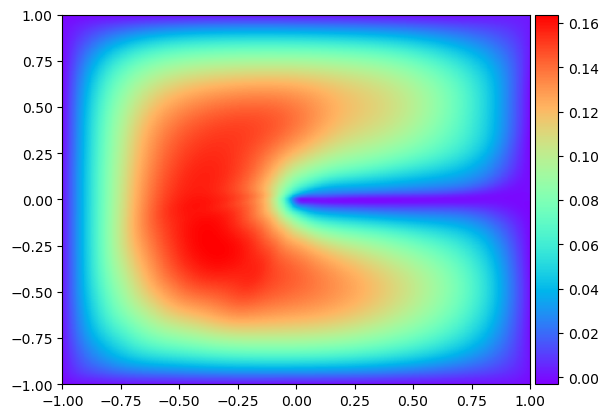

In [5]:
epochs = 50000

in_N = 2
m = 10
out_N = 1

print(torch.cuda.is_available())
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
# Notice that the real code is "device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')"

model = drrnn(in_N, m, out_N).to(device)
model.apply(weights_init)
criteon = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)
print(model)

# x = torch.cat((xr, xb), dim=0)

# if 2 < m:
#     y = torch.zeros(x.shape[0], m - 2)
#     x = torch.cat((x, y), dim=1)
# # print(x.shape)
best_loss, best_epoch = 1000, 0
for epoch in range(epochs+1):

    # generate the data set
    xr = get_interior_points()
    xb = get_boundary_points()

    xr = xr.to(device)
    xb = xb.to(device)

    xr.requires_grad_()
    output_r = model(xr)
    output_b = model(xb)
    grads = autograd.grad(outputs=output_r, inputs=xr,
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    loss_r = 0.5 * torch.sum(torch.pow(grads, 2),dim=1)- output_r
    loss_r = torch.mean(loss_r)
    loss_b = torch.mean(torch.pow(output_b,2))
    loss = 4 * loss_r + 9 * 500 * loss_b

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch:', epoch, 'loss:', loss.item(), 'loss_r:', (4 * loss_r).item(), 'loss_b:', (9 *500 * loss_b).item())
        if epoch > int(4 * epochs / 5):
            if torch.abs(loss) < best_loss:
                best_loss = torch.abs(loss).item()
                best_epoch = epoch
                torch.save(model.state_dict(), 'new_best_deep_ritz1.mdl')
print('best epoch:', best_epoch, 'best loss:', best_loss)

# plot figure
model.load_state_dict(torch.load('new_best_deep_ritz1.mdl'))
print('load from ckpt!')
with torch.no_grad():
    x1 = torch.linspace(-1, 1, 1001)
    x2 = torch.linspace(-1, 1, 1001)
    X, Y = torch.meshgrid(x1, x2)
    Z = torch.cat((Y.flatten()[:, None], Y.T.flatten()[:, None]), dim=1)
    # if 2 < m:
    #     y = torch.zeros(Z.shape[0], m - 2)
    #     Z = torch.cat((Z, y), dim=1)
    Z = Z.to(device)
    pred = model(Z)

plt.figure()
pred = pred.cpu().numpy()
pred = pred.reshape(1001, 1001)
ax = plt.subplot(1, 1, 1)
h = plt.imshow(pred, interpolation='nearest', cmap='rainbow',
                   extent=[-1, 1, -1, 1],
                   origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(h, cax=cax)
plt.show()


## Test on the high dimensional poisson equation (d = 10)
Consider the following high dimensional Possion Equation
$$
    \begin{cases}
      -\Delta u = 0, & u\in (0,1)^{10}\\
      u = \sum_{k=1}^{5}x_{2k-1}x_{2k}, & u\in \partial(0,1)^{10}\\
      \end{cases}.
$$


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim, autograd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


class PowerReLU(nn.Module):
    """
    Implements simga(x)^(power)
    Applies a power of the rectified linear unit element-wise.

    NOTE: inplace may not be working.
    Can set inplace for inplace operation if desired.
    BUT I don't think it is working now.

    INPUT:
        x -- size (N,*) tensor where * is any number of additional
             dimensions
    OUTPUT:
        y -- size (N,*)
    """

    def __init__(self, inplace=False, power=3):
        super(PowerReLU, self).__init__()
        self.inplace = inplace
        self.power = power

    def forward(self, input):
        y = F.relu(input, inplace=self.inplace)
        return torch.pow(y, self.power)
    
class Block(nn.Module):
    """
    IMplementation of the block used in the Deep Ritz
    Paper

    Parameters:
    in_N  -- dimension of the input
    width -- number of nodes in the interior middle layer
    out_N -- dimension of the output
    phi   -- activation function used
    """

    def __init__(self, in_N, width, out_N, phi=PowerReLU()):
        super(Block, self).__init__()
        # create the necessary linear layers
        self.L1 = nn.Linear(in_N, width)
        self.L2 = nn.Linear(width, out_N)
        # choose appropriate activation function
        self.phi = nn.ReLU()

    def forward(self, x):
        return self.phi(self.L2(self.phi(self.L1(x)))) + x
    
class drrnn(nn.Module):
    """
    drrnn -- Deep Ritz Residual Neural Network

    Implements a network with the architecture used in the
    deep ritz method paper

    Parameters:
        in_N  -- input dimension
        out_N -- output dimension
        m     -- width of layers that form blocks
        depth -- number of blocks to be stacked
        phi   -- the activation function
    """

    def __init__(self, in_N, m, out_N, depth=4, phi=PowerReLU()):
        super(drrnn, self).__init__()
        # set parameters
        self.in_N = in_N
        self.m = m
        self.out_N = out_N
        self.depth = depth
        self.phi = nn.ReLU()

        # list for holding all the blocks
        self.stack = nn.ModuleList()

        # add first layer to list
        self.stack.append(nn.Linear(in_N, m))

        # add middle blocks to list
        for i in range(depth):
            self.stack.append(Block(m, m, m))

        # add output linear layer
        self.stack.append(nn.Linear(m, out_N))

    def forward(self, x):
        # first layer
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

def get_interior_points(N=1000,d=10):
    """
    randomly sample N points from interior of [-1,1]^d
    """
    return torch.rand(N,d) * 2 - 1

def get_boundary_points(N=100):
    xb = torch.rand(2 * 10 * N, 10)
    for i in range(10):
        xb[2 * i * N: (2 * i + 1) * N, i] = 0.
        xb[(2 * i + 1) * N: (2 * i + 2) * N, i] = 1.

    return xb
def u(x):
    u = 0
    for i in range(5):
        u += x[:,2*i:2*i+1] * x[:,2*i+1:2*i+2]
    return u

In [3]:
epochs = 50000
in_N = 10
m = 10
out_N = 1

print(torch.cuda.is_available())
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model = drrnn(in_N, m, out_N).to(device)
model.apply(weights_init)
criteon = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(model)


best_loss, best_epoch = 1000, 0
for epoch in range(epochs+1):

    # generate the data set
    xr = get_interior_points()
    xb = get_boundary_points()

    xr = xr.to(device)
    xb = xb.to(device)

    xr.requires_grad_()
    output_r = model(xr)
    output_b = model(xb)
    grads = autograd.grad(outputs=output_r, inputs=xr,
                              grad_outputs=torch.ones_like(output_r),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    grads_sum = torch.sum(torch.pow(grads, 2), dim=1)
    u1 = 0.5 * grads_sum
    u1 = torch.mean(u1)
    u2 = torch.mean(torch.pow(output_b-u(xb), 2))
    loss = u1 + 20 * 500 * u2

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch:', epoch, 'loss:', loss.item(), 'loss_r:', u1.item(), 'loss_b:', (20* 500 * u2).item())
        if epoch > int(4 * epochs / 5):
            if torch.abs(loss) < best_loss:
                    best_loss = loss.item()
                    best_epoch = epoch
                    torch.save(model.state_dict(), 'new_best_high_dim1.mdl')
print('best epoch:', best_epoch, 'best loss:', best_loss)


# print results
model.load_state_dict(torch.load('new_best_high_dim1.mdl'))
print('load from ckpt!')

with torch.no_grad():
    x = torch.rand(100000,10)
    u_exact = u(x)
    x = x.to(device)
    u_pred = model(x)
err_l2 = torch.sqrt(torch.mean(torch.pow(u_pred-u_exact,2))) / torch.sqrt(torch.mean(torch.pow(u_exact,2)))
print('L^2 relative error:', err_l2)


False
drrnn(
  (phi): ReLU()
  (stack): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (2): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (3): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (4): Block(
      (L1): Linear(in_features=10, out_features=10, bias=True)
      (L2): Linear(in_features=10, out_features=10, bias=True)
      (phi): ReLU()
    )
    (5): Linear(in_features=10, out_features=1, bias=True)
  )
)
epoch: 0 loss: 102479.46875 loss_r: 12.346245765686035 loss_b: 102467.125
epoch: 100 loss: 1674.2874755859375 loss_r: 5.418412208557129 loss_b: 1668.86